<a href="https://colab.research.google.com/github/luqmanbuang/Aircraft-Engine-Lifetime-Prediction-with-Machine-Learning/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#The dataset

Dataset is divided into training and test subsets consisting of multiple multivariate time series. Each time series is from a different engine unit – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine unit starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. However in the dataset used in this project, df_FD001, the engines are only sujected to a single operational setting and hence does not contribute to much degradation learning. Additionaly, the data is contaminated with sensor noise.
<br>  
The engine is operating normally at the start of each time series and is assumed to be at perfect health. It develops a fault at some point during the series. In the <ins>training set</ins>, the fault grows in magnitude until system failure. **In the test set, the time series ends some time prior to system failure.**
<br>  
The **objective of this project is to predict the number of remaining operational cycles before failure in the test set**, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. A vector of the actual Remaining Useful Life (RUL) values for the test data is available and will be used to compare the accuracy of the prediction model.  
<br> 
The screenshot below shows the first five rows of engine unit 1. Each row represents a screenshot of the same engine unit (unit 1) at different times — called cycles. In the test and train dataset, there are 100 of such engine units with varying numbers of cycles each. 21 columns representing data from 21 different engine sensors are included along each row. For simplicity, these sensors are called sensors S1 to S21. For example, Sensor 1 is the sensor that detects the total temperature at the fan inlet while Sensor 8 tracks the fan speed of the engine in RPM.
<br>  
![Dataset example](https://drive.google.com/uc?id=1hEt0xMQv-6IOwO1A5kMkbL8wkPIBlkcX) 
<br>  
Degradation of the engine health can be observed by plotting the data from these sensors. In a sample plot below, we can see that as the engine's health deteriorates over time the engine's core speed increases. A possible explanation why this might occur is that the engine needs to generate a higher RPM in order to produce or maintain the same power output. Similar degradation patterns can be observed in the other sensors. The goal is to <ins>let the machine learning algorithms learn the degradation patterns and its corelation to the engine's health</ins> in order to ultimately predict the engine's Remaining Useful Life in operation. The training dataset will be used to train the machine learning algorithm, while the test dataset is used to validate its accuracy.  
<br>  
![sensor degradation](https://drive.google.com/uc?id=1n5YQFTOmvdPyro86zeCB3VDMXhLTD54G)

#1. Importing and preprocessing the dataset

##1.1 Data feature selection 
Firstly, both the train and test datasets are uploaded into the notebook and preprocessed to prepare it for the machine learning process. Plotting the different sensors for every engine units uncovers that some sensors do not contain characteristics that show engine degradation compared to those seen in the example in the previous section. Instead they exhibit constant and flatline data output. Sensor 1 of Unit 29 is an example of flatline data: 
<br>  

![Dataset example](https://drive.google.com/uc?id=10nQjcDX1uF8JvT2PPKtmmTGc9yLtoos3)

Sensors such as S2 and S3 are useful for the machine learning process as they show regressive characteristics. Howvever in contrary, sensors such as S5 and S6 are removed as they are flat and will not contribute to the machine learning process. In total, sensors Op3, S1, S5, S6, S9, S16, S10, S18 and S19 were removed.
<br>

![Dataset example](https://drive.google.com/uc?id=1JMP_FgtpRi8dx3MO441snXgc18phsOt_)



##1.2 Feature scaling
After they are removed, the train and test datasets are combined together for feature scaling using `sklearn.preprocessing.MinMaxScaler()`. Feature scaling of the data is done so that each column (the sensor data) of the dataset share a common scale. Their features are normalized between between zero and one without distorting the differences in the range of their values. After their values are normalized, the train and test datasets are split again for the model training and testing process.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

#Importing both test and train datasets
df_test_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/test_FD001.txt', sep=' ', header=None)
df_train_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/train_FD001.txt', sep=' ', header=None)


# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
df_test_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_train_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

# data preprocessing; removing unnecessary data
df_test_FD001.drop(['Op3','S1', 'S5', 'S6', 'S9', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df_train_FD001.drop(['Op3','S1', 'S5', 'S6', 'S9', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)

# test dataset begins with unit 101 to differentiate from the train dataset
df_test_FD001['unit'] += 100

# Combine the two datasets into a single dataframe
df_combined = pd.concat([df_train_FD001, df_test_FD001]) 

# Perform scalling on the the combined dataset so that their scale is the same
scaler = MinMaxScaler()
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

# Split them again after performing scalling
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

# After separation, the first unit of the test dataset is reset to 0 again
df_test_FD001['unit'] -= 100

#2. Calculation

##2.1 Remaining Useful Life (RUL)
The Remaining Useful Life of an engine unit at a cycle is calculated by subtracting its final cycle *(after which the engine stops operating or also the maximum/total number of cycles)*, to the current cycle that we want to calculate its RUL. This value represents the amount of cycles remaining before engine failure. *For an engine that lasts 200 cycles, the RUL of that engine will be 200 at its very first cycle, and 0 at its final or maximum cycle.*  
![RUL calculation](https://drive.google.com/uc?id=1plHNZOQJv5CNyfkJ70AaHsya_7VBoMhj)

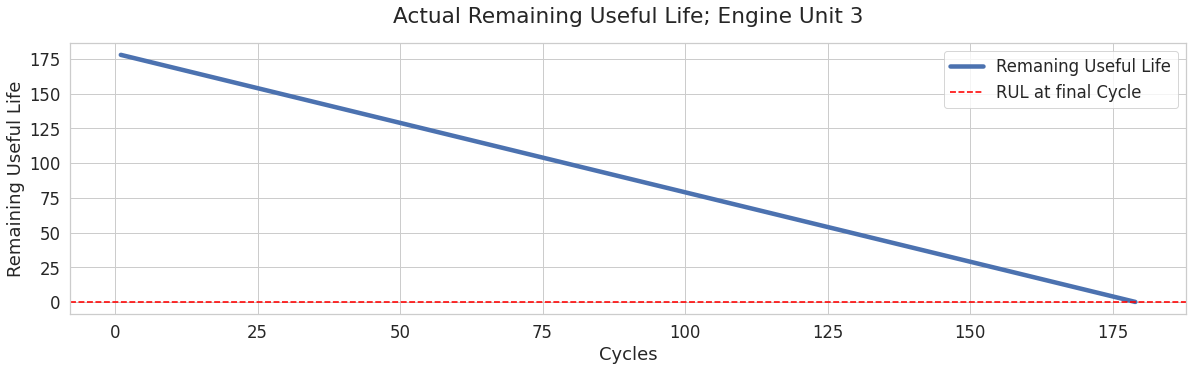

In [ ]:
# Finding the maximum cycle of an engine unit which is used to find its Remaining Useful Life (RUL)
df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Final Cycle"}, inplace=True)

df_train_FD001['RUL'] = df_train_FD001['Final Cycle'] - df_train_FD001['cycles']

# Defining the Health Index, where value of 1 denotes healthy engine and 0 denotes failure
def HealthIndex(dataFrame,q):
    return(dataFrame.RUL[q]-dataFrame.RUL.min()) / (dataFrame.RUL.max()-dataFrame.RUL.min())

healthIndex_q = []
healthIndex = []

for i in range(df_train_FD001['unit'].min(), df_train_FD001['unit'].max() + 1):
    dataFrame = df_train_FD001[df_train_FD001.unit == i]
    dataFrame = dataFrame.reset_index(drop = True)
    for q in range(len(dataFrame)):
        healthIndex_q = HealthIndex(dataFrame, q)
        healthIndex.append(healthIndex_q)

df_train_FD001['Health Index'] = healthIndex

import seaborn as sns
sns.set(font_scale=1.5)
plt.figure(figsize = (20, 5))
sns.set_style('whitegrid')

y_axis =  df_train_FD001['RUL'][df_train_FD001['unit']==3]
x_axis = df_train_FD001['cycles'][df_train_FD001['unit'] == 3]

plt.plot(x_axis, y_axis, linewidth=4.5, label='Remaning Useful Life')
plt.axhline(0, color="red", linestyle='dashed', linewidth=1.6, label='RUL at final Cycle')
plt.xlabel('Cycles')
plt.ylabel('Remaining Useful Life')
plt.title('Actual Remaining Useful Life; Engine Unit 3', x=0.5, y=1.05, ha='center', fontsize='large');
plt.legend(loc='best');

##2.1 Health Index (H.I.)
The RUL can be used to calculate the health index of the engine. The health index of the engine represents the state of the engine's health where values closer to one represents a healthier engine and values closer to 0 signifies that the engine reaching the end of its operational life. The health index is caculated by dividing the the current cycle of the time series by the final cycle of the unit. *For example, calculating the H.I of an engine at its very first cycle where it is at best health returns a value of one as the RUL of the engine at the first cycle is also equals to the final cycle of the engine.*

![HI calculation](https://drive.google.com/uc?id=1Zbk_7BXxpUSJWeA2JppKUnvlXF9-E8vV)

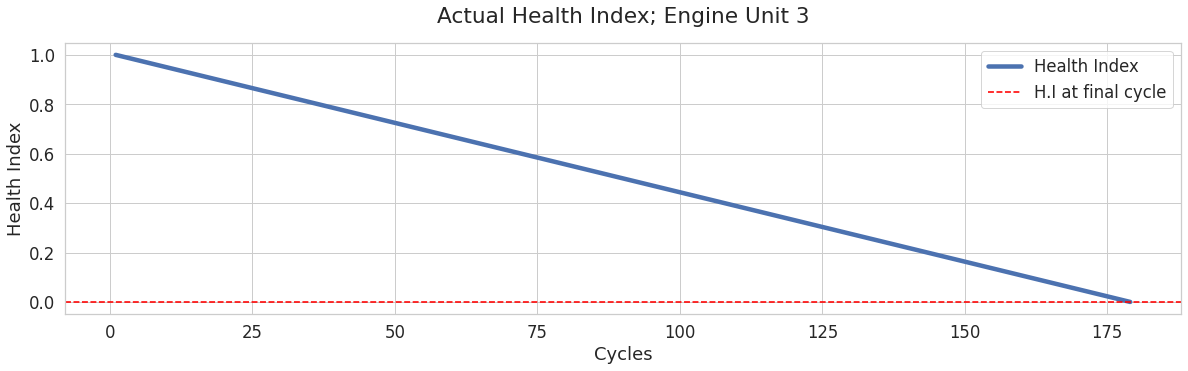

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize = (20, 5))
sns.set_style('whitegrid')

y_axis =  df_train_FD001['Health Index'][df_train_FD001['unit']==3]
x_axis = df_train_FD001['cycles'][df_train_FD001['unit'] == 3]

plt.plot(x_axis, y_axis, linewidth=4.5, label='Health Index')
plt.axhline(0, color="red", linestyle='dashed', linewidth=1.6, label='H.I at final cycle')
plt.xlabel('Cycles')
plt.ylabel('Health Index')
plt.title('Actual Health Index; Engine Unit 3', x=0.5, y=1.05, ha='center', fontsize='large')
plt.legend(loc='best');

#3. Defining test and train data
##Train data
Sensor data values from the **train dataset** are defined as X_train and the Health Index calculated in the earlier section defined as y_train. The X_train and y_train data will be used to fit and train the machine learning models.  
##Test data
Sensor data values from the **test dataset** is defined as X_test. What is being predicted is the Health Index of the engine. <ins>When X_test is passed into the trained machine learning model, it is able to return a prediction of engines' Health Index.</ins>

In [ ]:
# Defining train values that will be used to train the machine learning model
X_train = df_train_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['Health Index']].values.ravel()

# Defining test values that will be used to perform prediction based on the trained model
X_test = df_test_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

#4. Machine Learning Models
Three machine learning models are used to predict the RUL of an engine.  
The models used are:

1.   Linear Regression (Lreg)
2.   K Nearest Neighbour Regressor (KNR)
3.   Artificial Neural Networks (NN)

## 4.1. Linear Regression model
The default linear regression model is used in this project

In [ ]:
from sklearn.linear_model import LinearRegression
lreg_model = LinearRegression()
lreg_model.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 4.2. KNN Regressor Model
The default linear regression model is used in this project

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knr_model = KNeighborsRegressor(n_neighbors=12)
knr_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                    weights='uniform')

## 4.3. Neural Network Model
The neural network model is defined with 16 inputs nodes that comes from the engine sensor datas. They are then passed through a single hidden layer with 50 nodes, with a single output. Where is then trained over 55 epochs.

In [ ]:
# Importing keras deep learning API into colab notebook
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor

# Defining Neural Network model
nn_model = Sequential()
nn_model.add(Dense(50, input_dim=16, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(1, activation='relu'))

# Compiling model
nn_model.compile(loss='mean_squared_error', optimizer='adam')

# Training the Neural Network model
nn_model.fit(X_train, y_train, epochs = 55, shuffle=True, verbose = 0)

## 4.4. Saved Neural Network Model
Alternatively, the best Neural Network model as a result of multiple runs was saved and can be uploaded again so that the most accurate model can be retrieved again for an accurate prediction. This method is used for the subsequent sections.

In [ ]:
import keras

# from tensorflow import keras
nn_model = keras.models.load_model('/content/gdrive/My Drive/Capstone/BestModel')

#5. `MachineLearningModel()` class and its methods
The `MachineLearningModel()` class is created to reduce code duplication when calling multiple machine learning models to predict the engine degradation. The details of its methods are further explained below.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set(font_scale=1.5)
plt.style.context("seaborn-whitegrid")
sns.set_style('whitegrid')

class MachineLearningModel:
  def __init__(self,model,name,testDataFrame, X_test, OutputDataFrame = None):
    self.model = model
    self.name = name
    self.testDataFrame = testDataFrame
    self.X_test = X_test

    # Values of the predictions and calculations are stored in the test dataframe by default unless an alternate dataframe is specified 
    if OutputDataFrame is not None:
      self.OutputDataFrame = OutputDataFrame
    else:
      self.OutputDataFrame = self.testDataFrame

  def predict(self):    
    # Function predicts the Health Index values based on the trained machine learning model.
    Prediction = self.model.predict(self.X_test)

    # The predicted H.I. values are appended into the dataframe 
    self.OutputDataFrame[f'Pred_H.I._{self.name}'] = Prediction

    # Calculating the predicted final cycle of the engine units      
    self.OutputDataFrame[f'PredFinalCycle_{self.name}'] = self.OutputDataFrame['cycles'] / (1 - self.OutputDataFrame[f'Pred_H.I._{self.name}'])

  def PlotPredFinalCycle(self,displayUnit=1, display_mean = True):
    # Returning the average final cycle value of a particular engine unit
    df = self.OutputDataFrame[f'PredFinalCycle_{self.name}']
    meanValue = df[(self.OutputDataFrame['unit'] == displayUnit)][-10:].mean()
    print(f'Mean value of last 10 cycles of engine unit {displayUnit}: {meanValue}') 

    # plotting the predicted final cycles
    plt.figure(figsize = (18, 10))
    y_axis = df[(self.OutputDataFrame['unit'] == displayUnit)]
    x_axis = self.OutputDataFrame['cycles'][self.OutputDataFrame['unit'] == displayUnit]

    plt.plot(x_axis, y_axis, linewidth=2.5, label='Predicted Final Cycle')
    plt.xlabel('Cycles')
    plt.ylabel('Predicted Final Cycle')
    if display_mean == True:
      plt.axhline(meanValue, color="red", linestyle='dashed', linewidth=1.6, label='Calculated mean')

    # set title and axis labels
    errorDist = plt.title(f'Predicted Final Cycle of engine unit {displayUnit}', x=0.5, y=1.05, ha='center', fontsize='xx-large')
    plt.setp(errorDist, color='black')
    plt.legend(loc='best')

  def DataFrame(self, displayUnit=None, remove_sensor_data=False):
    df = self.OutputDataFrame
    if displayUnit:
      df = df[df['unit'] == displayUnit]

    # function returns dataframe
    droppedColumns = ['Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']
    if remove_sensor_data == True:
      df.drop(droppedColumns, axis=1, errors='ignore', inplace=True)
    return df

  def CalcPredFinalCycle(self):
    df = self.OutputDataFrame[f'PredFinalCycle_{self.name}']

    # Returns a uniform PredFinalCycle based on the calculated average of the last 10 cycles 
    for i in range(self.OutputDataFrame['unit'].min(), self.OutputDataFrame['unit'].max() + 1):
        df[(self.OutputDataFrame['unit'] == i)] = df[(self.OutputDataFrame['unit'] == i)][-10:].mean()
  
  def CalcPredRUL(self):
    self.OutputDataFrame[[f'Pred_RUL_{self.name}']] = self.OutputDataFrame[f'PredFinalCycle_{self.name}'] * self.OutputDataFrame[f'Pred_H.I._{self.name}']

    # Appending the RUL values of each engine unit into an array
    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
    pred_final = []
    for i in range(1,101):
      pred_final.append(df[(self.OutputDataFrame['unit'] == i)].min())

    self.predicted = pred_final
    return pred_final  

  def PlotRUL(self, displayUnit = None, line_width=2.5, show_final_RUL=False, show_best_fit=False):
    # Visualizing the predicted cycles of the engine units in the test dataset.
    # x-axis represents the cycles
    engine_unit = ''
    if displayUnit is None:
      y_axis =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
      x_axis = range(len(self.OutputDataFrame['cycles']))
      plt.figure(figsize = (18, 10)) 
    else:
      y_axis =  self.OutputDataFrame[f'Pred_RUL_{self.name}'][self.OutputDataFrame['unit'] == displayUnit]
      x_axis = self.OutputDataFrame['cycles'][self.OutputDataFrame['unit'] == displayUnit]
      engine_unit = f'Engine {displayUnit}, '
      plt.figure(figsize = (20, 5)) 
   
    if show_final_RUL:
      min_RUL = y_axis[(self.OutputDataFrame['unit'] == displayUnit)].min()
      plt.axhline(min_RUL, color="red", linestyle='dashed', linewidth=1.6, label='Final Cycle')
      print(f"RUL of engine unit {displayUnit} is {min_RUL}")
      

    plt.plot(x_axis, y_axis, linewidth=line_width, label='Predicted RUL')
    plt.xlabel('Cycles')
    plt.ylabel('Predicted RUL')
    plt.title(f'Predicted Remaining Useful Life; {engine_unit}{self.name}', x=0.5, y=1.05, ha='center', fontsize='x-large')
    
    if show_best_fit:
      bf_x_axis = x_axis.values.reshape(-1,1)
      RUL_lreg = LinearRegression()
      RUL_lreg.fit(bf_x_axis,y_axis)
      best_fit = RUL_lreg.predict(bf_x_axis)
      plt.plot(x_axis, best_fit, linewidth=.75*line_width, label='Best fit', linestyle='dashed')
    
    plt.legend(loc='best')

  def RUL_bestFit(self):
 
    for i in range(self.OutputDataFrame['unit'].min(), self.OutputDataFrame['unit'].max() + 1):
      x_axis = self.OutputDataFrame['cycles'][self.OutputDataFrame['unit'] == i]
      y_axis =  self.OutputDataFrame[f'Pred_RUL_{self.name}'][self.OutputDataFrame['unit'] == i]

      bf_x_axis = x_axis.values.reshape(-1,1)
      RUL_lreg = LinearRegression()
      RUL_lreg.fit(bf_x_axis,y_axis)
      self.OutputDataFrame[f'Pred_RUL_{self.name}'][self.OutputDataFrame['unit'] == i] = RUL_lreg.predict(bf_x_axis)

    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}']
    pred_final = []
    for i in range(1,101):
      pred_final.append(df[(self.OutputDataFrame['unit'] == i)].min())

    self.predicted = pred_final
    return pred_final  

  def DisplayEngineRUL(self, displayUnit=1):
    # Returning the Remaining useful life of an engine unit of the test dataset.
    # It is found by returning the minumum cycle to failure value of each engine unit
    df =  self.OutputDataFrame[f'Pred_RUL_{self.name}'] 
    value = df[(self.OutputDataFrame['unit'] == displayUnit)].min()
    print(f'Predicted RUL of unit {displayUnit}: {value}')

  def GetRMSE(self,actual,predicted=None):
    if predicted is None:
      predicted = self.predicted
    
    # Calculating the Root Mean Square Error of the actual and predicted values
    RMSE = mean_squared_error(actual, predicted, squared=False)
    return RMSE


The Results fataframe is defined where the results of the predictions and calculation for each ML models are stored. 

In [ ]:
Results_nn = df_test_FD001[['unit', 'cycles']]
Results_knr = df_test_FD001[['unit', 'cycles']]
Results_lreg = df_test_FD001[['unit', 'cycles']]

#6. Prediction
Using the `MachineLearningModel()` class, the prediction of engine RUL using multiple machine learning models can be made without code duplication. In this section, the process is explained using the best performing model: Neural Networks.

##6.1 Neural Network model prediction
The `MachineLearningModel()` class accepts six attributes such as:

1.   Trained machine learning model
2.   The name of the model in a string data type used when storing their results — *eg.; 'nn', 'lreg', 'knr'*
3.   The test dataframe where the results are stored by default
4.   The values of the test set in `numpy.ndarray` type that is used to predict the model
5.   If specified, an alternative dataframe where the results are stored

The `MachineLearningClass.predict()` method inputs the X_test data into the prediction model and saves the output into the dataframe. This output is named "Pred_H.I._nn" in this example or the Predicted Health Index of the engine. Using the predicted H.I, the final cycle of the engine can be calculated by dividing the current cycle by one minus the Health Index. 

![predicted final cycle](https://drive.google.com/uc?id=1250YEDm1IfsoAWqYbXZASC6d5i8qjpfb)

```
  def predict(self):    
    # Function predicts the Health Index values based on the trained machine learning model.
    Prediction = self.model.predict(self.X_test)

    # The predicted H.I. values are appended into the dataframe 
    self.OutputDataFrame[f'Pred_H.I._{self.name}'] = Prediction

    # Calculating the predicted final cycle of the engine units      
    self.OutputDataFrame[f'PredFinalCycle_{self.name}'] = self.OutputDataFrame['cycles'] / (1 - self.OutputDataFrame[f'Pred_H.I._{self.name}'])
```




In [ ]:
NeuralNetwork = MachineLearningModel(nn_model, 'nn', df_test_FD001, X_test, Results_nn)
NeuralNetwork.predict()

By displaying the last five rows of the dataframe, the predicted RUL of unit 100 based can be calculated by subtracting the final cycle with the predicted final cycle (222 - 198) which returns a value of 19. In other words, this means that it is predicted that the engine's operational life will end in approximately 24 cycles.

![Predicted RUL calculation](https://drive.google.com/uc?id=1U37h-6AQnS6VbtkgDK65uIVv7GdXGksO)

In [ ]:
# displaying the last 5 rows of the dataframe
NeuralNetwork.DataFrame(100).tail()

,unit,cycles,Pred_H.I._nn,PredFinalCycle_nn,Pred_RUL_nn
13091,100,194,0.137112,224.826355,31.226948
13092,100,195,0.144416,227.914627,32.890553
13093,100,196,0.146855,229.738129,33.445866
13094,100,197,0.132384,227.058945,30.150166
13095,100,198,0.111879,222.942581,25.480204



Taking unit 20 for example, it is observed that the value of the predicted final cycle throughout the timeseries is noisy and unstable. In a perfect world this should not happen as the final cycle should be same throughout. As a result, in this project the **<ins>average value of the last ten cycles is used to represent the predicted final cycle of the entire engine unit</ins>**. For the purpose of this project, these average values are refered as the adjusted predicted final cycle. For the example plotted below, the dotted line represent the averaged value used.  

Mean value of last 10 cycles of engine unit 20: 209.6955108642578


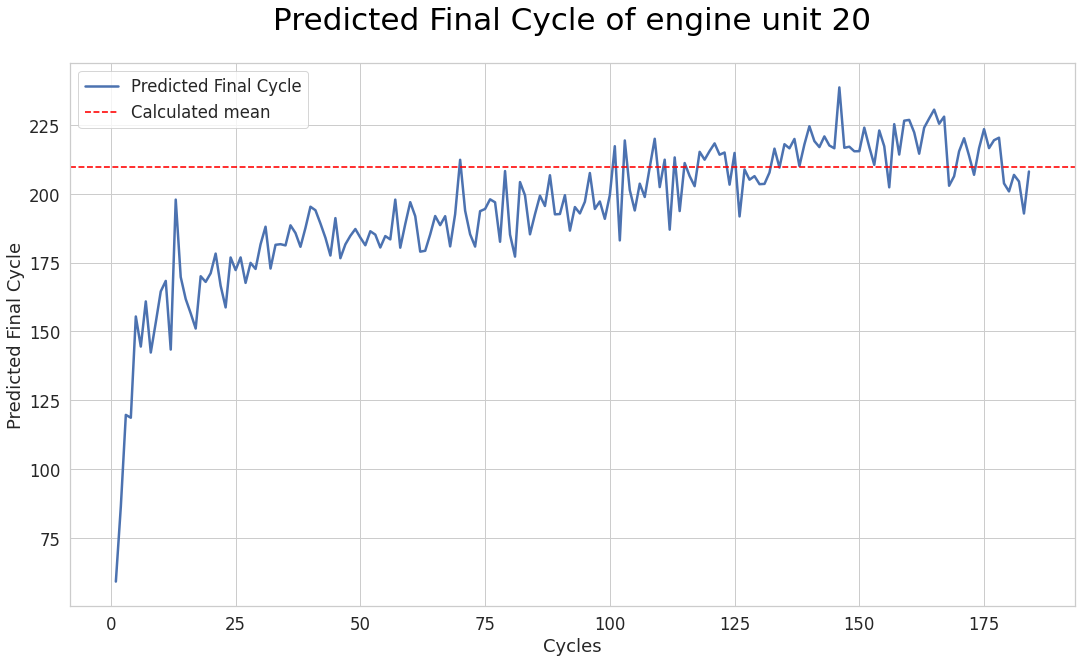

In [ ]:
NeuralNetwork.PlotPredFinalCycle(20)

After averaging the predicted final cycle' values, we can see that it's values are now stable throughout the timeseries. Now we can proceed to calculate the RUL of the engine.

Mean value of last 10 cycles of engine unit 20: 209.69552612304688


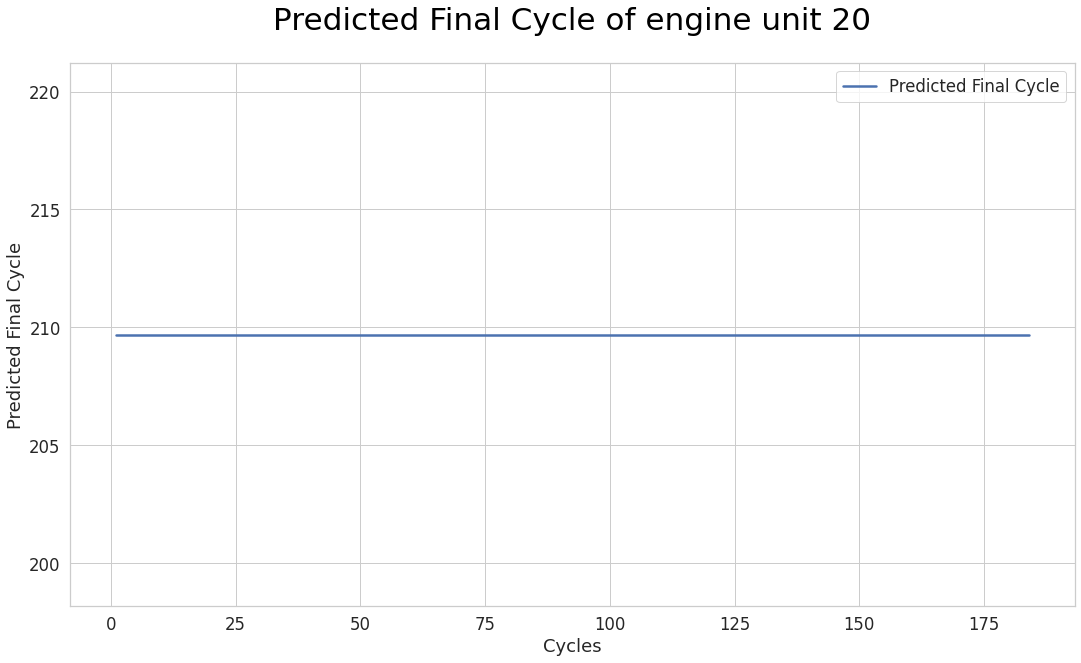

In [ ]:
NeuralNetwork.CalcPredFinalCycle()
NeuralNetwork.PlotPredFinalCycle(20, display_mean=False)

With the values of the predicted final cycle averaged and stable throughout the timeseries, the Predicted RUL can now be calculated by multiplying the predicted final cycle with the Predicted Health Index.



In [ ]:
RUL_nn = NeuralNetwork.CalcPredRUL()
NeuralNetwork.DataFrame().head()

,unit,cycles,Pred_H.I._nn,PredFinalCycle_nn,Pred_RUL_nn
0,1,1,0.982264,186.023041,182.723694
1,1,2,0.982387,186.023041,182.746613
2,1,3,0.984519,186.023041,183.143143
3,1,4,0.964011,186.023041,179.328339
4,1,5,0.967212,186.023041,179.923782


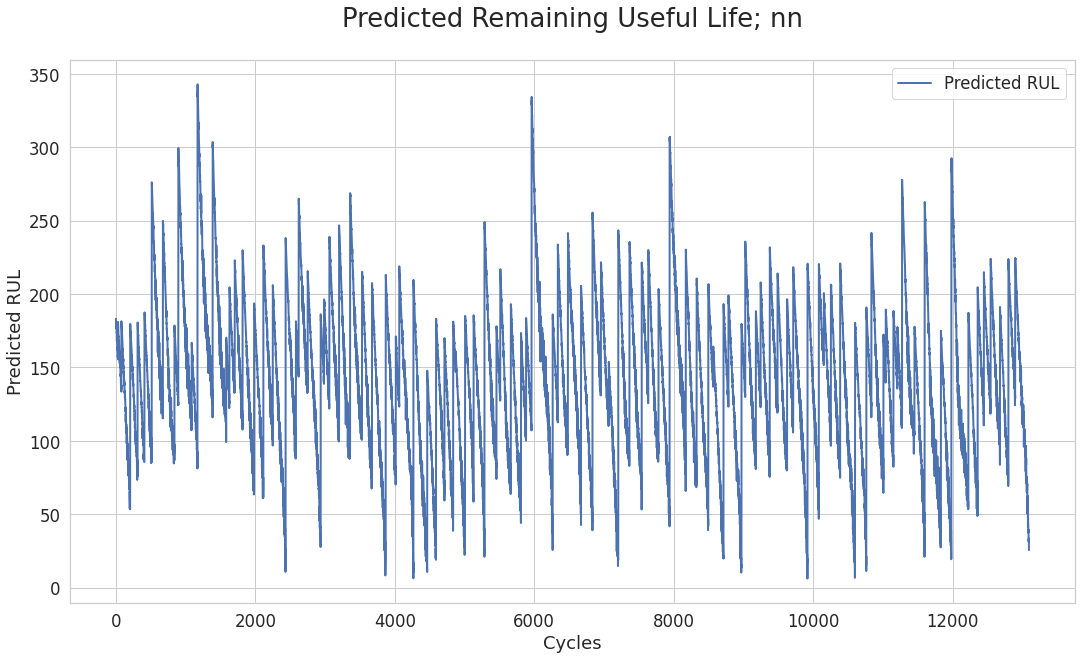

In [ ]:
NeuralNetwork.PlotRUL(line_width=2)

We display engine unit 50 to have a better observation of the RUL results. In this example, can see that the RUL value decreases as the cycle as the cycle number increases. It shows that the engine's health is degrading as the cycle increases. At this point we can safely say that our method to predict the RUL is working. 

RUL of engine unit 20 is 10.720968246459961


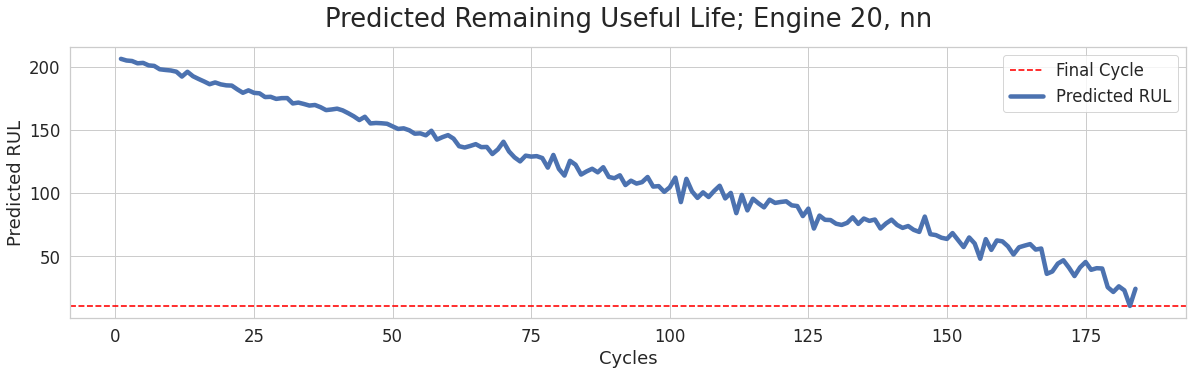

In [ ]:
NeuralNetwork.PlotRUL(20, line_width=4.5, show_final_RUL=True)

To determine the accuracy of the model however, we will compare the RUL of the engines at their final cycle with the actual/true values. This will be done at the end when prediction is done with all three models. The other two models must first go through the same steps to predict the RUL of the test dataset.

## 6.2 K Nearest Neighbour Regressor prediction

In [ ]:
KNRegressor = MachineLearningModel(knr_model, 'knr', df_test_FD001, X_test, Results_knr)
KNRegressor.predict()
KNRegressor.CalcPredFinalCycle()
RUL_knr = KNRegressor.CalcPredRUL()
KNRegressor.DataFrame()

,unit,cycles,Pred_H.I._knr,PredFinalCycle_knr,Pred_RUL_knr
0,1,1,1.000000,200.993359,200.993359
1,1,2,0.995298,200.993359,200.048301
2,1,3,0.989815,200.993359,198.946302
3,1,4,0.986484,200.993359,198.276766
4,1,5,0.979469,200.993359,196.866760
...,...,...,...,...,...
13091,100,194,0.146055,235.520245,34.398851
13092,100,195,0.211693,235.520245,49.857898
13093,100,196,0.141655,235.520245,33.362532
13094,100,197,0.173862,235.520245,40.947919


##6.3 Linear regression model prediction

In [ ]:
LinearRegression = MachineLearningModel(lreg_model, 'lreg', df_test_FD001, X_test, Results_lreg)
LinearRegression.predict()
LinearRegression.CalcPredFinalCycle()
RUL_lreg = LinearRegression.CalcPredRUL()
LinearRegression.DataFrame()

,unit,cycles,Pred_H.I._lreg,PredFinalCycle_lreg,Pred_RUL_lreg
0,1,1,0.903406,149.373038,134.944430
1,1,2,0.910623,149.373038,136.022475
2,1,3,0.880623,149.373038,131.541287
3,1,4,0.885530,149.373038,132.274341
4,1,5,0.905769,149.373038,135.297434
...,...,...,...,...,...
13091,100,194,0.135680,227.602371,30.881130
13092,100,195,0.135120,227.602371,30.753589
13093,100,196,0.138762,227.602371,31.582520
13094,100,197,0.127759,227.602371,29.078230


#7. Results and analysis
At the end, we observe the prediction results of the Neural Network, KNN model and the Linear Regression model. Several statistical methods are used to validate the accuracy of the predictive models. They revolve around comparing the values of the predicted results and the actual RUL values.

##7.1 Residual (e)
Residuals in a statistical or machine learning model are the differences between observed and predicted values of data. They are a diagnostic measure used when assessing the quality of a model. They are also known as errors.

We upload the actual/true RUL values of each engine units and compare their predicted RUL values. The difference between them - called residuals - are stored to validate the accuracy of our machine learning models. 
![difference calculation](https://drive.google.com/uc?id=1Un5nvlf3f5i63EdRZs5s2SUqPIrgGN-P)

In [ ]:
FinalResult = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
FinalResult = FinalResult.dropna(axis=1, how='all')
FinalResult.columns = ["Actual RUL"]

unit = []
for i in range(1,101):
  unit.append(i)
FinalResult['Unit'] = unit

names = ['lreg', 'knr', 'nn']
models = [RUL_lreg, RUL_knr, RUL_nn]

for i in range(len(names)):
  predRUL_column_name = f'Pred_RUL_{names[i]}'
  diff_column_name = f'diff_{names[i]}'
  FinalResult[predRUL_column_name] = models[i]
  FinalResult[diff_column_name] = FinalResult['Actual RUL'] - FinalResult[predRUL_column_name]

FinalResult

,Actual RUL,Unit,Pred_RUL_lreg,diff_lreg,Pred_RUL_knr,diff_knr,Pred_RUL_nn,diff_nn
0,112,1,119.995048,-7.995048,169.072196,-57.072196,155.577972,-43.577972
1,98,2,105.525296,-7.525296,147.369550,-49.369550,133.558121,-35.558121
2,69,3,81.817143,-12.817143,49.362621,19.637379,53.309608,15.690392
3,82,4,99.963074,-17.963074,74.435711,7.564289,73.373322,8.626678
4,91,5,106.407354,-15.407354,92.050954,-1.050954,85.590111,5.409889
...,...,...,...,...,...,...,...,...
95,137,96,152.315784,-15.315784,108.940084,28.059916,118.467880,18.532120
96,82,97,108.914928,-26.914928,77.499891,4.500109,83.692139,-1.692139
97,59,98,93.455681,-34.455681,71.053977,-12.053977,69.172104,-10.172104
98,117,99,165.614785,-48.614785,120.392189,-3.392189,124.278015,-7.278015


##7.2 Kernel Density Estimation (KDE)
Plotting the Kernel Density Estimation (KDE) of the models below, we can have a better grasp of the performance on our ML models. It gives a quick sneak peak of the error distribution; can be used as a quick eye test to compare accuracy between the machine learning models. The mode of the error distribution are generally centered near zero. However, it can be observed that the mode for all three errors are generally slightly shifted towards the left. This can be interpreted that there is a slightly more probability for the difference between the actual and predicted RUL values of our predictive models to be negative *— or in other words the prediction has slightly more chance to overshoot the actual RUL than not.* 

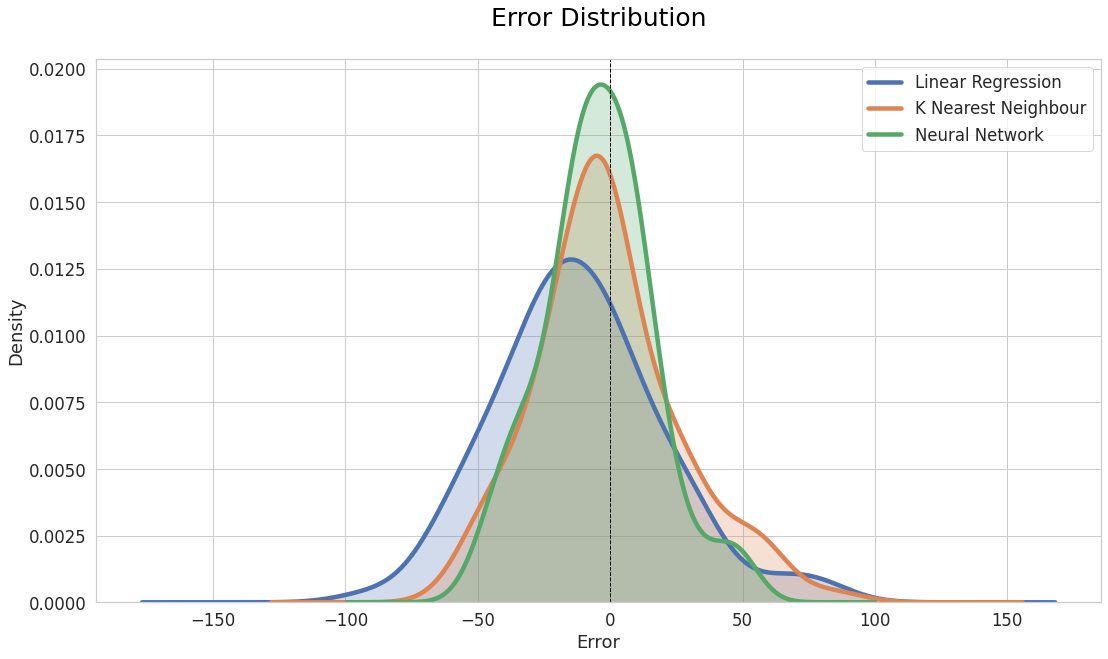

In [ ]:
import matplotlib
names = ['lreg', 'knr', 'nn']
lables = ['Linear Regression','K Nearest Neighbour','Neural Network']

plt.figure(figsize=(18,10))
sns.set_style('whitegrid')

for i in range(len(names)):
  FinalResult[f'diff_{names[i]}'].plot(label = lables[i], kind = 'kde', linewidth=4.5, legend = True)
  sns.kdeplot(FinalResult[f'diff_{names[i]}'], shade=True)
plt.axvline(0, color="black", linestyle='dashed', linewidth=1)

# set title and axis labels
errorDist = plt.title('Error Distribution', x=0.5, y=1.05, ha='center', fontsize='25')
plt.setp(errorDist, color = 'black')
plt.xlabel('Error')
plt.show();

##7.3 Standard Deviation (σ)
Calling the `describe()` function it displays the a summary of statistics pertaining to the prediction errors. <ins>Standard deviation</ins> is the measure of dispersion, or how spread out values are, in a data. It’s represented by the sigma (σ) symbol and found by taking the square root of the variance. The variance is just the average of the squared differences from the mean. 
  
    
![Standard deviation](https://www.gstatic.com/education/formulas/images_long_sheet/en/population_standard_deviation.svg)
<br>

We observe the **standard deviation** of the three predictive models:

1.   Artificial Neural Networks: 20.772
2.   K Nearest Regressor: 27.157
3.   Linear Regression: 31.562

Using this metric is a crucial test of the machine learning models' accuracy against the actual data. In addition, standard deviation can be used to measure confidence in a model’s statistical conclusions.

In [ ]:
Error = FinalResult[['diff_nn','diff_knr','diff_lreg']]
Error.describe()

,diff_nn,diff_knr,diff_lreg
count,100.000000,100.000000,100.000000
mean,-4.305059,-1.013148,-11.657916
std,20.771619,27.157247,31.561666
min,-49.607895,-57.072196,-90.599290
25%,-15.518355,-17.650478,-30.932689
50%,-4.750236,-2.532193,-13.343738
75%,7.493423,12.150219,7.466374
max,50.266850,84.880618,81.888109


##7.4 Boxplot and its outliers
A boxplot visualizes the Interquartile Range (IQR), the Q1 and Q2 values, maximum and minimum values, and also the outliers in the data. Outliers can be seen as the values outside of the "whiskers" of the boxplot. They are defined as values lesser than **Q1 - (1.5 x IQR)** and values more than **Q3 + (1.5 x IQR)** . In the box and whisker plot of the error distribution, it is observed that there aren't many outliers in the data. Ignoring the outliers, the Neural Networks has the smallest range and also the smallest interquartile range (IQR). 

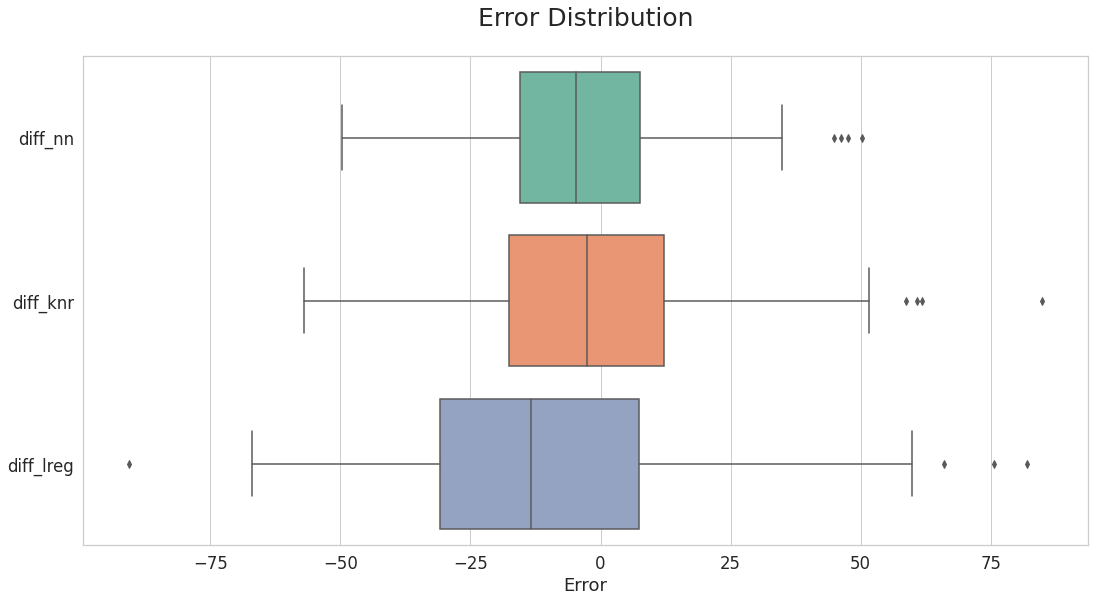

In [ ]:
Error = FinalResult[['diff_nn','diff_knr','diff_lreg']]

plt.figure(figsize = (18, 9))
boxplot = sns.boxplot(data=Error, orient="h", palette="Set2", showfliers = True)
plt.title('Error Distribution', x=0.5, y=1.05, ha='center', fontsize = '25')
plt.xlabel('Error');

##7.5 Root Mean Square Error (RMSE)
RMSE is calculated by taking the square root of the average of the squared differences between the actual and predicted values. This value is able to represent the estimation of the standard deviation σ of a typical observed value from the model’s prediction. In other words, a lower RMSE value means a more accurate prediction. The values obtained in this project is compared with the RMSE of existing works to ascertain the accuracy standing of our model.
<br>  
![RMSE calculation](https://miro.medium.com/max/725/1*lqDsPkfXPGen32Uem1PTNg.png) 

In [ ]:
RMSE_nn = NeuralNetwork.GetRMSE(FinalResult['Actual RUL'])
RMSE_knr = KNRegressor.GetRMSE(FinalResult['Actual RUL'])
RMSE_lreg = LinearRegression.GetRMSE(FinalResult['Actual RUL'])

print('Neural Network RMSE:', RMSE_nn)
print('K Nearest Neighbour RMSE:', RMSE_knr)
print('Linear Regression RMSE:', RMSE_lreg)

Neural Network RMSE: 21.111112570983536
K Nearest Neighbour RMSE: 27.040106378523973
Linear Regression RMSE: 33.49752785361099


#8. Summary
In this work, the performance of three Machine Learning algorithms are studied. Machine Learning is used to predict the Health Index of engines in this study. The engine’s Remaining Useful Life is then calculated using the predicted H.I.

<br>

Three machine learning models were used to predict the RUL of an engine:
1.   Linear Regression (Lreg)
2.   K Nearest Neighbour Regressor (KNR)
3.   Artificial Neural Networks (NN)

The Health Index and the Remaining Useful Life of a turbofan engine is successfully predicted using this approach. The model accuracy is then assesed.

Accuracy of the prediction analyzed by:
1. Residual
2. Kernel Distribution Estimation
3. Standard Deviation
4. Root Mean Square Error; RMSE
5. Cross-validation of RMSE

Cross validation of RMSE with works attempting similar predictive algorithm revealed that the predictive models yielded similar or better results. Using this model can be used to help airlines save maintenance costs by reducing the frequency of pre-scheduled engine checks that takes away the aircraft from active service.

#Appendices
##a. Sensor names
![Sensors](https://drive.google.com/uc?id=1YEqSg4rKSAnme66ZAl2sETCWLtbNv7oW) 